In [220]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor


In [221]:
class Data(Dataset):
    def __init__(self, filename):
        df = pd.read_pickle(filename)
        dfx = df.drop(columns=['X'])
        dfy = df.drop(columns=['T'])
        
        x = dfx.iloc[:,:].values
        y = dfy.iloc[:, :].values

        x = np.array(x, dtype=np.float32)
        self.X = torch.from_numpy(x)
        print(f'{filename} X size: {self.X.shape}')


        y = np.array(y, dtype=np.float32)   
        self.y = torch.from_numpy(y)
        print(f'{filename} Y size: {self.y.shape}')
        

    
    def __len__(self):
        return len(self.y)

    def __getparams__(self):
        return self.X, self.y

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [222]:
# TRAIN E TEST DATA: T => 0 -> 5 (TIME UNITS)

train_data = Data(filename='training-data.pkl')
test_data = Data(filename='test-data.pkl')

train_dataloader = DataLoader(train_data, shuffle=True)
test_dataloader = DataLoader(test_data, shuffle=True)


for X, y in train_dataloader:
    print(f"Shape of X [N, Params]: {X.shape}")
    print(f"Shape of y [N, Params]: {y.shape} {y.dtype}")
    break

training-data.pkl X size: torch.Size([75, 1])
training-data.pkl Y size: torch.Size([75, 1])
test-data.pkl X size: torch.Size([75, 1])
test-data.pkl Y size: torch.Size([75, 1])
Shape of X [N, Params]: torch.Size([1, 1])
Shape of y [N, Params]: torch.Size([1, 1]) torch.float32


In [223]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")


# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear = nn.Sequential(
            nn.Linear(1, 32),
            nn.Sigmoid(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


Using cuda device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Sequential(
    (0): Linear(in_features=1, out_features=32, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=32, out_features=1, bias=True)
  )
)


In [224]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss = loss.item()
            #print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: Avg loss: {test_loss:>8f} \n")

def solution(w0, Beta, Amplitude, Phase, Size, TimeInterval):
    w1 = np.sqrt(pow(w0, 2) - pow(Beta, 2))
    
    #x(t) = A*np.exp(-Beta*time)*np.cos(w1*t + phase)
    
    x = []
    tempo = []
    for iter in range(Size):
        t = (TimeInterval * iter)
        tempo.append(t)
        xt = Amplitude * np.exp(-Beta*t) * np.cos(w1*t + Phase)
        x.append(xt)

    x = np.array(x, dtype=np.float16)
    t = np.array(t, dtype=np.float16)

    return x, tempo

In [225]:
epochs = 20000
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
Test Error: Avg loss: 2.964602 

Epoch 2
-------------------------------
Test Error: Avg loss: 2.957967 

Epoch 3
-------------------------------
Test Error: Avg loss: 2.950138 

Epoch 4
-------------------------------
Test Error: Avg loss: 2.944664 

Epoch 5
-------------------------------
Test Error: Avg loss: 2.942479 

Epoch 6
-------------------------------
Test Error: Avg loss: 2.933126 

Epoch 7
-------------------------------
Test Error: Avg loss: 2.927761 

Epoch 8
-------------------------------
Test Error: Avg loss: 2.924193 

Epoch 9
-------------------------------
Test Error: Avg loss: 2.920489 

Epoch 10
-------------------------------
Test Error: Avg loss: 2.913987 

Epoch 11
-------------------------------
Test Error: Avg loss: 2.917168 

Epoch 12
-------------------------------
Test Error: Avg loss: 2.906334 

Epoch 13
-------------------------------
Test Error: Avg loss: 2.903537 

Epoch 14
-------------------------------
Test E

In [226]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


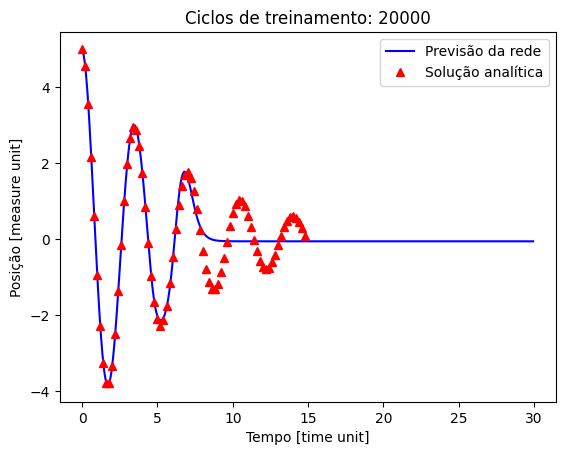

In [231]:
model = NeuralNetwork().to(device)
model.load_state_dict(torch.load("model.pth"))

params = [1.80, 0.15, 5.00, 0.00]

prediction_time_units = 30
trained_time_units = 15
DT   = 0.2
Size =  (int)(trained_time_units/DT)

x, t = solution(params[0], params[1], params[2], params[3], Size, DT)

feval = np.arange(0, prediction_time_units, 0.05, dtype=np.float32)
ieval = feval[:, np.newaxis, np.newaxis]

eval = torch.from_numpy(ieval)
eval = eval.to(device)

# eval = torch.tensor([[0.1]], dtype=torch.float32)
# print(eval.shape)
# eval = eval.to(device)

predictions = []
with torch.no_grad():
    for i in range(len(ieval)):
        pred = model(eval[i])
        pred = torch.squeeze(pred)
        pred = torch.squeeze(pred)
        pred = torch.squeeze(pred)
        pred = pred.cpu()
        pred = pred.numpy()
        predictions.append(pred)

plt.plot(feval, predictions, 'b-', label='Previsão da rede')
plt.plot(t, x, 'r^', label='Solução analítica')
plt.legend()
plt.title(f'Ciclos de treinamento: {epochs}')
plt.xlabel('Tempo [time unit]')
plt.ylabel('Posição [measure unit]')
plt.show()